In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm
# from torch import datasets

from torch import _vmap_internals
from torchvision import datasets, transforms
from functorch import vmap
from torchvision.transforms import ToTensor

# import torch.nn.functional as F

import pandas as pd

In [2]:
from cfollmer.objectives import log_g, relative_entropy_control_cost, stl_relative_entropy_control_cost_xu
from cfollmer.sampler_utils import FollmerSDE
from cfollmer.drifts import *
from cfollmer.trainers import basic_batched_trainer

functorch succesfully imported


# The Model

\begin{align}
\theta &\sim \mathcal{N}(\theta | 0, \sigma_w^2 \mathbb{I}) \\
y_i | x_i, \theta &\sim  \mathrm{Cat}\left[\mathrm{NN}_{\theta}\left(x_i \right)\right]
\end{align}

We want samples from $p(\theta | \{(y_i, x_i)\})$. Note $f(x; \theta)$ is a neural net with params $\theta$

## Loading the iris dataset

In [3]:
images_train = datasets.MNIST("../data/mnist/", download=True, transform=ToTensor(), train=True)
images_test = datasets.MNIST("../data/mnist/", download=True, transform=ToTensor(), train=False)

transform = torch.nn.Sequential(transforms.Normalize((0.1307,), (0.3081)))

In [4]:
images_train.data.shape

torch.Size([60000, 28, 28])

In [5]:
X_train, y_train = images_train.data, images_train.targets
X_test, y_test = images_test.data, images_test.targets

X_train = transform(X_train.float())
X_test = transform(X_test.float())

y_train = F.one_hot(y_train)
y_test = F.one_hot(y_test)

# X_train = np.concatenate((X_train, np.ones((X_train.shape[0],X_train.shape[1]))), axis=1)
# X_test = np.concatenate((X_test, np.ones((X_test.shape[0],X_train.shape[1]))), axis=1)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

/tmp/ipykernel_31737/1347329722.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_train, dtype=torch.float32, device=device), \
/tmp/ipykernel_31737/1347329722.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_test, dtype=torch.float32, device=device), \
/tmp/ipykernel_31737/1347329722.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_train, dtype=torch.float32, device=device), \
/tmp/ipykernel_31737/1347329722.py:7: UserWarning: To copy construct from a tensor, it is recommended to use s

In [7]:
X_train.shape

torch.Size([60000, 28, 28])

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [8]:
class LeNet5(torch.nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = torch.nn.Sequential(            
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=120),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

from functorch import make_functional






class LeNet5Fun(object):
    
    def __init__(
        self, input_dim=1, output_dim=1, depth=None,
        width=20, width_seq=None, device="cpu", activation=F.relu
    ):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim 
        self.activation = activation
        
        self.model = LeNet5(n_classes=10)
        self.func_model, self.params = make_functional(self.model)
        
        
        self.dim = sum([math.prod(x.shape) for x in self.params])
        
        self.size_tuples = [p.shape for p in self.params]

    def get_params_from_array(self, array):
        cur_index = 0
        param_list = []
        for s in self.size_tuples:
            step_number = math.prod(s)
            param_list.append(array[cur_index:cur_index+step_number].reshape(s))
            cur_index += step_number
        return param_list
    
    def forward(self, x, Θ):
        Θ = self.get_params_from_array(Θ)
        return self.func_model(Θ, x)



In [9]:
dim = X_train.shape[1]
out_dim = y_train.shape[1]

# net = ClassificationNetwork(
#     dim, out_dim, device=device, depth=1, width=50, activation=F.tanh
# )
net = LeNet5Fun()


def gaussian_prior(Θ, σ_w=3.8):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w


def log_likelihood_vmap_nn(Θ, X, y, net=net):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    
    def loss(θ):
        preds = net.forward(X, θ)
        cel = torch.nn.CrossEntropyLoss(reduction="sum")
#         import pdb; pdb.set_trace()
        ll_cel = -1.0 * cel(preds, y.argmax(dim=1))
        return ll_cel
    
    batched_loss =  vmap(loss)

    return batched_loss(Θ)

In [10]:
net.dim

44426

In [11]:
class SimpleForwardNetBN_larger(AbstractDrift):

    def __init__(self, input_dim=1, width=300, activation=torch.nn.Softplus):
        super(SimpleForwardNetBN_larger, self).__init__()
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, input_dim )
        )
        
        self.nn[-1].weight.data.fill_(0.0)


γ =  0.1**2
Δt=0.01

dim= net.dim

prior = gaussian_prior

sde, losses = basic_batched_trainer(
    γ, Δt, prior, log_likelihood_vmap_nn, dim, X_train.reshape(-1,1,28,28), y_train,
    method="euler", stl="stl_xu", adjoint=False, optimizer=None,
    num_steps=79, batch_size_data=int(X_train.shape[0] // 20), batch_size_Θ=30,
    batchnorm=True, device=device, lr=0.0001, drift=SimpleForwardNetBN_larger, schedule="uniform",
    γ_min= 0.1**2, γ_max= 0.4**2
)

  0%|          | 0/79 [00:00<?, ?it/s]

/local/scratch/home/fav25/hjb2/lib/python3.8/site-packages/torch/nn/functional.py:2378: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-t07f5mpb/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
/local/scratch/home/fav25/hjb2/lib/python3.8/site-packages/torch/nn/functional.py:2942: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::cross_entropy_loss. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-t07f5mpb/functorch/csrc/BatchedFallback.cpp:106.)
  return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)


1.6960827112197876
1.7166500091552734
1.7330795526504517
1.7196152210235596
1.651671051979065
1.5884760618209839
1.4036871194839478
1.2798196077346802
1.1249005794525146
0.9033806920051575
0.7390279769897461
0.6206254363059998
0.476980060338974
0.39369624853134155
0.2911602556705475
0.26078811287879944
0.13060130178928375
0.1005076989531517
0.04203454405069351
-0.020976228639483452
-0.07784675806760788
-0.04950717091560364
-0.11115044355392456
-0.13782377541065216
-0.16209064424037933
-0.20069517195224762
-0.2191692292690277
-0.2233324497938156
-0.2747950255870819
-0.23233062028884888
-0.29939115047454834
-0.30652865767478943
-0.29169318079948425
-0.33285239338874817
-0.344258189201355
-0.37027525901794434
-0.34104594588279724
-0.35482335090637207
-0.3695380389690399
-0.39507564902305603
-0.3938941955566406
-0.37779316306114197
-0.401852011680603
-0.3810427188873291
-0.4184652864933014
-0.42003941535949707
-0.4380367398262024
-0.42583727836608887
-0.445064514875412
-0.42867353558540344

-0.5177499651908875
-0.5178843140602112
-0.5372817516326904
-0.5203011631965637
-0.5435367226600647
-0.524146318435669
-0.49615100026130676
-0.5239524841308594
-0.5110782384872437
-0.49684369564056396
-0.5207894444465637
-0.4934364855289459
-0.5245131254196167
-0.5206199288368225
-0.5199262499809265
-0.5010809898376465
-0.5093575119972229
-0.5206947922706604
-0.533033549785614
-0.5145379900932312
-0.5177889466285706
-0.5178874731063843
-0.5073843598365784
-0.5368494987487793
-0.5304684042930603
-0.5131508111953735
-0.5310683846473694
-0.48769620060920715
-0.5164811015129089
-0.5093755125999451
-0.5095905065536499
-0.5289328098297119
-0.5354899168014526
-0.522897481918335
-0.5246502757072449
-0.5220800638198853
-0.5366208553314209
-0.5203928351402283
-0.5428689122200012
-0.5216640830039978
-0.4934418499469757
-0.522594153881073
-0.5301214456558228
-0.54118412733078
-0.5020854473114014
-0.5388450026512146
-0.5050864219665527
-0.5172852277755737
-0.5106538534164429
-0.5174733996391296
-0.

-0.5508491396903992
-0.530553936958313
-0.5134468674659729
-0.5318052172660828
-0.5098716020584106
-0.5238289833068848
-0.5335902571678162
-0.5311751365661621
-0.5206242799758911
-0.5360412001609802
-0.5256909728050232
-0.5374013185501099
-0.5216191411018372
-0.529878556728363
-0.5300170183181763
-0.5313544273376465
-0.5414072275161743
-0.5231736898422241
-0.5340124368667603
-0.49592655897140503
-0.5441533923149109
-0.48223480582237244
-0.5139981508255005
-0.526178240776062
-0.5068190693855286
-0.533254861831665
-0.5182589292526245
-0.49367305636405945
-0.49515119194984436
-0.48623156547546387
-0.5033935904502869
-0.503464937210083
-0.5502143502235413
-0.5163991451263428
-0.5251315832138062
-0.5199782848358154
-0.5260187387466431
-0.5190722346305847
-0.5550847053527832
-0.5063503980636597
-0.520051121711731
-0.51236891746521
-0.5214918255805969
-0.5156753659248352
-0.49985411763191223
-0.5317153334617615
-0.5206975936889648
-0.5179317593574524
-0.525216281414032
-0.5220448970794678
-0.

-0.5285442471504211
-0.5191594958305359
-0.5225018262863159
-0.5336624383926392
-0.5377469062805176
-0.530182957649231
-0.5228663086891174
-0.5189470648765564
-0.5246420502662659
-0.5297033786773682
-0.5471230149269104
-0.5450146198272705
-0.544823169708252
-0.5442025065422058
-0.5255005955696106
-0.5183727741241455
-0.5396707057952881
-0.5489407777786255
-0.5428522825241089
-0.5359956622123718
-0.5146759152412415
-0.5209023952484131
-0.5297985076904297
-0.5418591499328613
-0.5306465029716492
-0.5227605104446411
-0.5174424648284912
-0.5385802984237671
-0.5210449695587158
-0.5351582169532776
-0.5112058520317078
-0.5296859741210938
-0.5392109155654907
-0.5246307253837585
-0.5397690534591675
-0.5296059846878052
-0.5311675667762756
-0.5263268351554871
-0.5276607871055603
-0.49710220098495483
-0.5201163291931152
-0.5127891898155212
-0.5245069861412048
-0.5288599133491516
-0.5123634934425354
-0.5295038819313049
-0.5091747641563416
-0.5337113738059998
-0.4988567531108856
-0.5424922108650208
-

In [12]:
losses

[tensor(0.8926),
 tensor(-0.2547),
 tensor(-0.4263),
 tensor(-0.4754),
 tensor(-0.4905),
 tensor(-0.5041),
 tensor(-0.5060),
 tensor(-0.5075),
 tensor(-0.5168),
 tensor(-0.5138),
 tensor(-0.5215),
 tensor(-0.5094),
 tensor(-0.5130),
 tensor(-0.5204),
 tensor(-0.5193),
 tensor(-0.5191),
 tensor(-0.5216),
 tensor(-0.5242),
 tensor(-0.5205),
 tensor(-0.5178),
 tensor(-0.5177),
 tensor(-0.5163),
 tensor(-0.5222),
 tensor(-0.5192),
 tensor(-0.5151),
 tensor(-0.5170),
 tensor(-0.5258),
 tensor(-0.5229),
 tensor(-0.5251),
 tensor(-0.5309),
 tensor(-0.5174),
 tensor(-0.5209),
 tensor(-0.5084),
 tensor(-0.5295),
 tensor(-0.5294),
 tensor(-0.5244),
 tensor(-0.5205),
 tensor(-0.5272),
 tensor(-0.5301),
 tensor(-0.5264),
 tensor(-0.5273),
 tensor(-0.5291),
 tensor(-0.5147),
 tensor(-0.5198),
 tensor(-0.5304),
 tensor(-0.5205),
 tensor(-0.5285),
 tensor(-0.5349),
 tensor(-0.5318),
 tensor(-0.5168),
 tensor(-0.5259),
 tensor(-0.5273),
 tensor(-0.5273),
 tensor(-0.5247),
 tensor(-0.5243),
 tensor(-0.

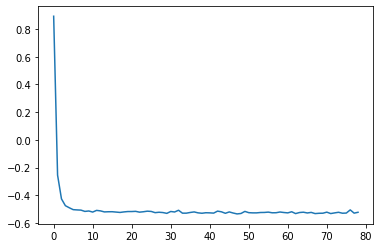

In [13]:
plt.plot(losses[:])

In [14]:
X_train.shape

torch.Size([60000, 28, 28])

In [15]:
t_size = int(math.ceil(1.0/Δt))
ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50
Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device)

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([ 1.,  1.,  3.,  6.,  9.,  7., 11.,  8.,  3.,  1.]),
 array([-0.64350617, -0.59688014, -0.55025417, -0.50362813, -0.45700213,
        -0.41037613, -0.3637501 , -0.3171241 , -0.2704981 , -0.22387208,
        -0.17724606], dtype=float32),
 <BarContainer object of 10 artists>)

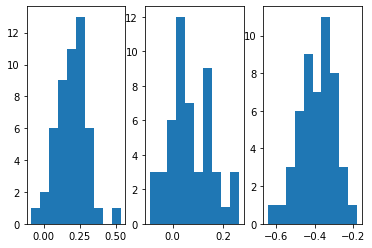

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,2].cpu().detach().numpy())

In [17]:
def predc(X, Θ):
    return torch.vstack([(net.forward(X, θ)[None,...]).softmax(dim=-1) for θ in Θ]).mean(dim=0)

In [19]:
import gc

from tqdm.notebook import tqdm

pred = []

gc.collect()
torch.cuda.empty_cache()

subsamp = 30

stride = 10

for i in tqdm(range(0,len(X_train), stride)):
    
    pred.append(predc(X_train[i:i+stride,...].reshape(-1,1,28,28), Θ_1[:subsamp,:]).cpu())
    gc.collect()
    torch.cuda.empty_cache()


  0%|          | 0/6000 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 47.46 GiB total capacity; 43.30 GiB already allocated; 3.31 MiB free; 46.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
pred = torch.vstack(pred)

In [21]:
# pred = torch.vstack(pred2)

In [22]:
subsamp = 30

In [23]:

((pred.argmax(dim=-1)).float().flatten().cpu() == y_train[:len(pred)].argmax(dim=-1).cpu() ).float().mean()

tensor(0.9716)

In [25]:
pred.shape

torch.Size([48860, 10])

In [19]:
import gc
gc.collect()
torch.cuda.empty_cache()

subsamp = 30

stride = 10


pred_test = []
for i in tqdm(range(0,len(X_test), stride)):
    
    pred_test.append(predc(X_test[i:i+stride,...].float().reshape(-1,1,28,28), Θ_1[:subsamp,:]).cpu())

    gc.collect()
    torch.cuda.empty_cache()

pred_test = (torch.vstack(pred_test))

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: 'list' object is not callable

In [20]:
pred_test = (torch.vstack(pred_test))

In [21]:
((pred_test.argmax(dim=-1)).float().flatten().cpu() == y_test.argmax(dim=-1).cpu()).float().mean()

tensor(0.9756)

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [ ]:
Θ_map = torch.zeros((1, dim), requires_grad=True, device=device)
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer_map.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, X_train, y_train) + gaussian_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()
        print(loss_map.item())
        optimizer_map.step()
        losses_map.append(loss_map.item())

Θ_map
pred_map = torch.sigmoid(X_train.mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map